In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating project at `~/Documents/eth_courses/notebooks/control`


In [8]:
using ModelingToolkit, DifferentialEquations
using GLMakie

### system

In [655]:
@variables t
D = Differential(t)

# first order system

function Plant(;name)
    sts = @variables (x(t))[1:2, 1:1]=0 (y(t))[1:2]=0 u(t)=0

    A = [0 1; 0 0];
    B = [0;1];
    
    eqn1 = D.(x) ~ A*x + B*u

    eqn2 = y .~ x
    
    eqns = vcat(eqn1, eqn2)
    
    ODESystem(eqns, t; name)
end

# feedback connection from output to reference
function Feedback(;name)
    sts = @variables (y(t))[1:2]=0 (r(t))[1:2]=0 (e(t))[1:2]=0
    eqs = e .~ r - y
    ODESystem(eqs, t; name)
end


Feedback (generic function with 1 method)

## Controller

In [656]:
# force control input to be constant over sampling time, actual control law applied inside callback
function Controller_Zero_Order_Hold(;name)
    sts = @variables u(t)=0 e(t)=0
    eqs= [
        D(u) ~ 0 
    ]
    ODESystem(eqs, t, sts, []; name)
end

Controller_Zero_Order_Hold (generic function with 1 method)

In [815]:
function digital_controller(int; controller_params=controller_params)

    # parameters
    kp, kd = controller_params.kp, controller_params.kd

    # get the error term from feedback system
    error = prob.f.observed(feedback.e, int.u, int.p, int.t)

    # output
    y = prob.f.observed(plant.y, int.u, int.p, int.t)

    # compute the control action 
    error_dot = cos(int.t) -  y[2]
    u = kp * error[1] +  kd * error_dot

    # find index of variable controller.u in the state vector
    i = indexof(controller.u, states(sys))

    # set the control input
    int.u[i] = u
end

digital_controller (generic function with 2 methods)

## Reference generator

In [860]:
function reference_generator(t)
    return sin(t)
end

reference_generator (generic function with 1 method)

## System building

In [861]:
@named plant = Plant()
@named controller = Controller_Zero_Order_Hold()
@named feedback = Feedback()

eqn1 = plant.u ~ controller.u
eqn2 = feedback.y .~ plant.y
eqn3 = controller.e .~ feedback.e
eqn4 = feedback.r[1] .~ reference_generator(t)

eqns = vcat(eqn1, eqn2, eqn3, eqn4)

# connect the subsystems
@named model = ODESystem(eqns,
    systems=[plant, controller, feedback])

sys = structural_simplify(model)

indexof(sym,syms) = findfirst(isequal(sym),syms)

indexof (generic function with 1 method)

In [894]:
# controller parameters
controller_params = (;kp=0.5, kd=25.5);

control_callback = PeriodicCallback(digital_controller, 0.01, initial_affect=true)

# sim parameters
tspan = (0.0, 10.0)

prob = ODEProblem(sys, [], tspan) 
@time sol = solve(prob, Tsit5(); callback=control_callback);

  0.090938 seconds (237.39 k allocations: 18.317 MiB)


## Plotting

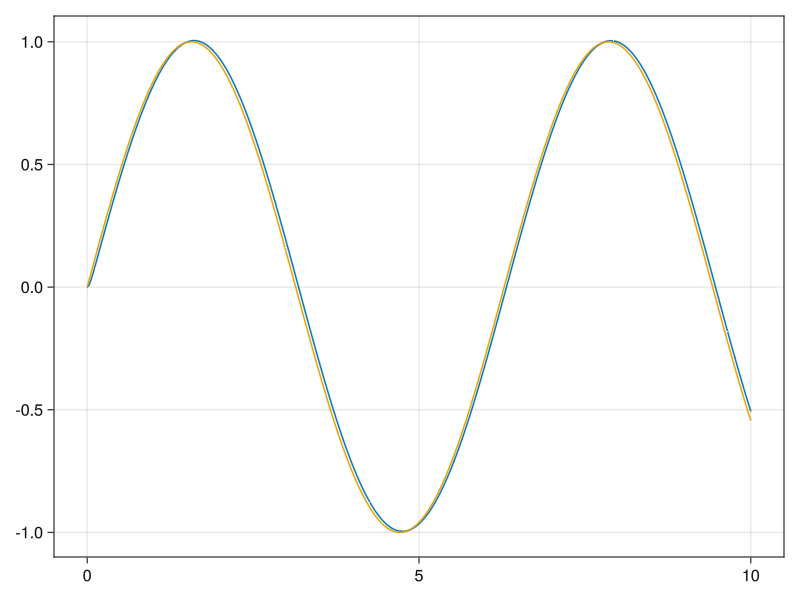

GLMakie.Screen(...)

In [895]:
fig = Figure()
ax = Axis(fig[1, 1])

lines!(ax, sol.t, sol[plant.y[1]])

#lines!(ax, sol.t, sol[controller.u])
lines!(ax, sol.t, sol[feedback.r[1]])

display(fig)